 # <font color = blue> Math 4432 Final Project Movie Revenue Prediction </font>

## Lee Jae Yeol 20308109

### 1.  Data Preprocessing
> * Encoding non - quantitative values
* Replacing 0 budget values 
* revenue log transformation
### 2. Model outline and Explanations 
> * Bagging
* Boosting
> > * Gradient Boosting Regressor Model
>> * XGBoodst Model
### 3. Experiments
> * Selecting multiple features
* Selecting all features
* Standarization
### 4. Result Table and Conclusion

In [47]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, plot_importance


To reduce time, I have shifted my working place from Jupyter to Google Colab to use GPU for a faster performance.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Preprocessing

In [3]:
df = pd.read_csv('/content/drive/MyDrive/data_final.csv')
df.head()

,revenue,budget,genres,keywords,production_companies,release_date,cast,crew
0,2787965087,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,961000000,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,880674609,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",2015-10-26,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,1084939099,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",2012-07-16,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,284139100,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",2012-03-07,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   revenue               3376 non-null   int64 
 1   budget                3376 non-null   int64 
 2   genres                3376 non-null   object
 3   keywords              3376 non-null   object
 4   production_companies  3376 non-null   object
 5   release_date          3376 non-null   object
 6   cast                  3376 non-null   object
 7   crew                  3376 non-null   object
dtypes: int64(2), object(6)
memory usage: 211.1+ KB


In [ ]:
df['revenue'].describe()

count    3.376000e+03
mean     1.170314e+08
std      1.834831e+08
min      5.000000e+00
25%      1.535290e+07
50%      5.175184e+07
75%      1.401651e+08
max      2.787965e+09
Name: revenue, dtype: float64

### 1 - 1. Encoding non quantitative values

Except for the revenue and the budget columns, all the other columns are object types. Since we need numeric data types to input in our ML models, we need to encode them to some sort of numeric values. <br>
I have implemented the preprocess function and the update function to convert the json(string) values to dictionary values. Then I have used multi label binarizer, an advanced type of one hot encoder used for columns with multiple labels as the name shows. Then, after deleting the original columns with the json values, I have concatenated the new multi label binarizer into the datafile for interpretation. I have only included the labels that have a count of more than 5 to prevent excessive additions of the labels.<br>


In [4]:
def preprocess(column):
    a = []
    for i in range(len(df[column])):
        b = []
        movie = json.loads(df[column][i])
        for j in range(len(movie)):
            b.append(movie[j]['name'])
        a.append(b)
    temp = pd.DataFrame({column: a})
    mlb = MultiLabelBinarizer()
    
    # creating a multilabel encoder
    encoder = pd.DataFrame(mlb.fit_transform(temp[column]), columns = mlb.classes_)
    print("# columns before constraint: {}" .format(len(encoder.columns)))
    # get only the columns that have a count of above 5 for dimension reduction
    encoder = encoder.loc[:,(encoder.astype(bool).sum(axis=0) >5) == True]
    print("# columns after constraint: {}" .format(len(encoder.columns)))

    return encoder

def updatefile(preprocessed_dataframe , originalcol, df):
    # drop original json column
    df.drop(columns=[originalcol], inplace = True)
    
    return pd.concat([df, preprocessed_dataframe], axis =1)

Since I do not know, which variables has a high correlation to our response variable 'revenue', along with the budget variable, I will initialize with encoding 'genres', 'production_companies' and the 'release date', the three that I assume to have some significant effect. 

In [ ]:
genres = preprocess("genres")
df = updatefile(genres, 'genres', df)
production_companies = preprocess("production_companies")
df = updatefile(production_companies, 'production_companies', df)
df['release_date'] =pd.to_datetime(df['release_date'], format = "%Y-%m-%d")
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_day'] = df['release_date'].dt.day
df = df.drop(columns=['release_date', 'keywords', 'cast','crew'])
df.columns = df.columns.str.replace(' ', '_')

# columns before constraint: 19
# columns after constraint: 19
# columns before constraint: 3736
# columns after constraint: 300


In [ ]:
len(df[df['budget']==0])

147

### 1 - 2. Replacing 0 budget values

Although there aren't any NaN values in the file, there are some 0 values in the budget which needs to be taken care of. Instead of filling them up with the mean or median values, I have calculated the coefficient of the linear regression for the budget and the revenue. After checking that the coefficient is nearly 3, I have filled up the 0 values with the corresponding revenue's values divided by 3. The correlation before and after the treatment between revenue and budget was only increased to 0.02 so I assume it didn't make a significant effect on the dependencies between the two. 

In [ ]:
lmodel = LinearRegression().fit(df['budget'].values.reshape(-1,1), df['revenue'].values.reshape(-1,1))
print("linear regression beta 1 value: %f" %lmodel.coef_)
print("budget, revenue correlation value: %f" %df['budget'].corr(df['revenue']))

linear regression beta 1 value: 2.939611
budget, revenue correlation value: 0.708214


In [ ]:
for i in range(len(df)):
    if df['budget'][i] == 0:
        df['budget'][i] = df['revenue'][i]/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print("budget, revenue correlation value after filling: %f" %df['budget'].corr(df['revenue']))

budget, revenue correlation value after filling: 0.710343


### 1 - 3. Revenue log transformation

Following the given project description, I have log transformed our response variable 'revenue', adding one to prevent the value to become negative. Log transformation is a powerful method in statistical modeling to fit the data to a normal bell curve. The skewness of the original data can be removed quite heavily and thus the statistical results obtained have more validity.

In [ ]:
x = df.drop(columns = 'revenue')
y = np.log(df['revenue']+1.0)
movies_num = np.shape(x)[0]
order = np.arange(movies_num)
np.random.shuffle(order)
x_train = x.values[order][:3000]
x_test = x.values[order][3000:]
y_train = y.values[order][:3000]
y_test = y.values[order][3000:]

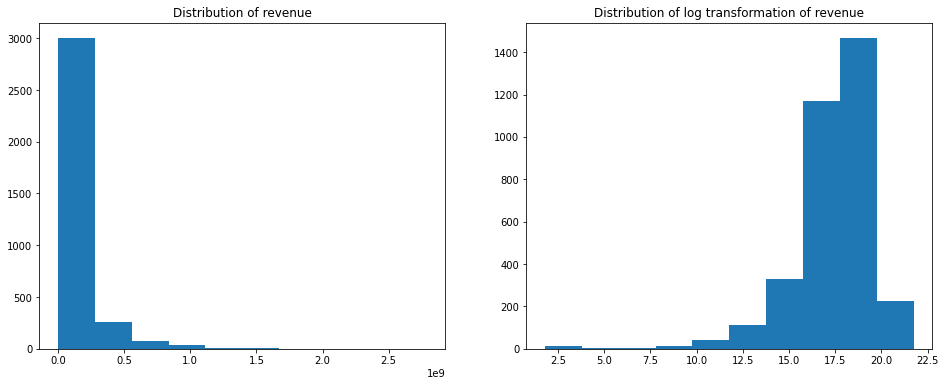

In [55]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(df['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(y);
plt.title('Distribution of log transformation of revenue');

## 2. Model outline and Explanations 


### Bagging
Ensemble Method is a powerful method in machine learning where several base models are combined to output an aggregated result. For decision trees, rather than obtaining the result from a single tree model, the model uses 'bootstrapping' and 'aggregating' technique, so called the Bagging. The subsets are chosen with replacement and the sizes equal to the original data set. An enhanced method for Bagging is the Random Forest models which randomly chooses different features for the trees. Hence, it decreases the corrleation between the bootstrapped trees. <br>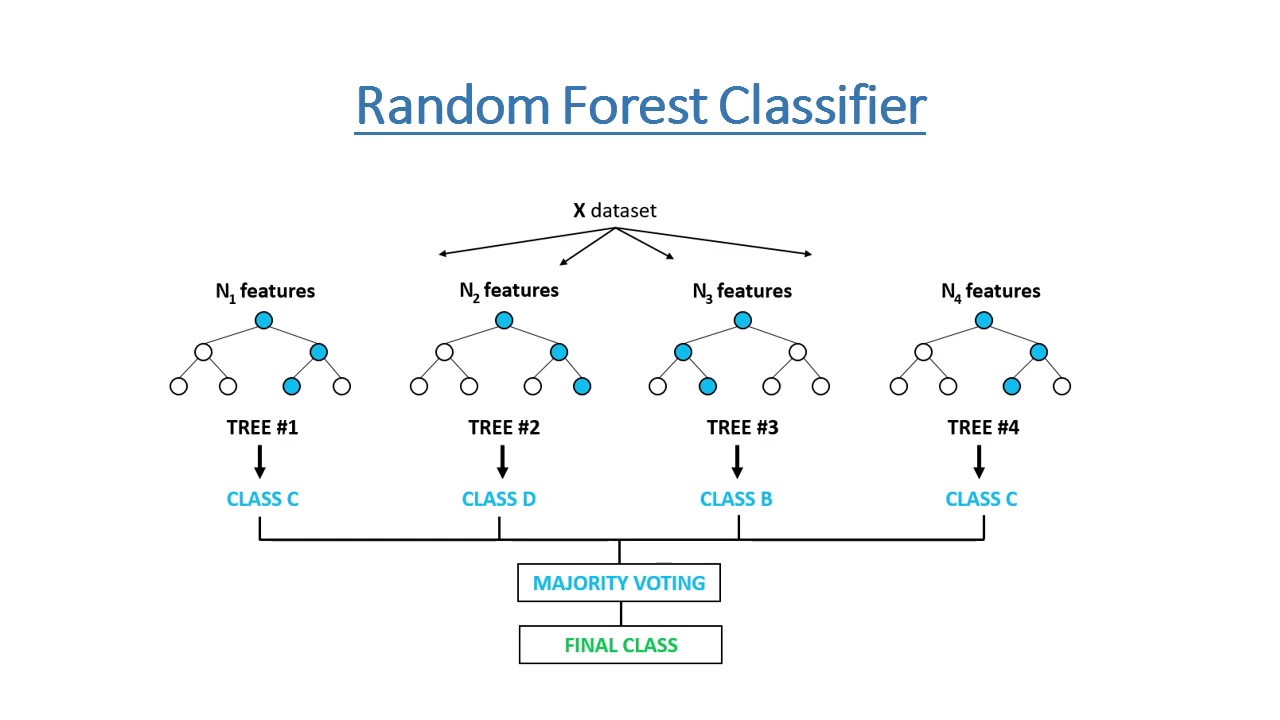
### Boosting
Boosting is another advanced technique of the ensemble method. A key difference to the Bagging method is that the next model for Boosting is derived from the previous model's errors(i.e. residuals). In other words, the gradient descent algorithm is implemented to minimize the loss function which is the error. Higher weights are given to the data values that are wrongly classified to highlight which data should the next tree model should put emphasis on. After the weak learners are created subsequentially, the stong learner, which is the final model, outputs the value that are the weighted aggregated values of the weak learners.
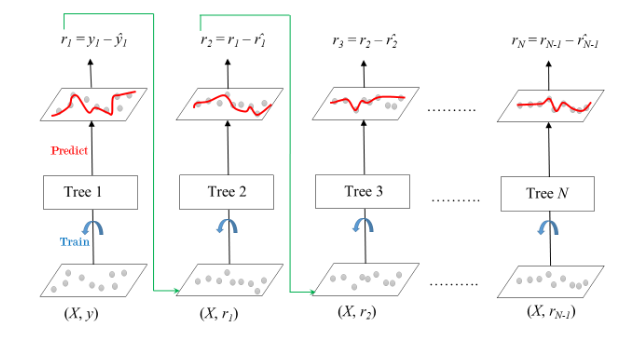
The two main models that I have implemented for my movie revenue prediction project are the Gradient Boosting Regressor model and the XGBoost model. <br>

### Gradient Boosting Regressor
Gradient Boosting Regressor is a representing model that implements the Boosting technique in Ensemble learning. To explain the key elements in the gradient boosting regressor model, a regression decision tree is fit to the pseudo residuals $r_{im} = - \big[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \big]_{F(x) = F_{m-1}(x)}$ and the gamma value $ \gamma_{jm} = \underset{\gamma}{\arg\min}\sum L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i))$ becomes the output value. The $F_{m-1}(x_i)$ term is used because the GBR model takes the previous prediction into account. Gradient Boost models can be used for both regression and classification problems. The difference is in the underlying loss functions for the methods. The full algorithm is very renouned and widespread therefore I will not copy it down.

### XGBoost 
XGBoost model is another very powerful Boosting model designed to be used with large, complicated data sets. The loss function implemented for the XGBoost regressor is ${\sum L(y_i, p_i)} + \frac1{2}\lambda\ O^2_{value} + \gamma T$ where <br>$L(y_i, p_i)$ is equal to $\frac1{2} (y_i - p_i)^2$, <br>$\lambda$ : the regularization term similar to the ridge regression and <br>$T$ : number of leaf nodes for a tree. <br>
XGBoost uses the terms <b>similarity scores</b> and <b>gain</b> to structurize the optimal decision tree for each iteration. The output value $O_{value}$ is derived from the second order Taylor approximation of the XGBoost loss function. 
$O_{value}$ = $\frac{\text{sum of the residuals}}{\text{number of residuals} + \lambda}$ <br> 
For a clearer interpretation. the sum of residuals are the sum of the <b>gradient</b> $g  = \frac{\partial}{\partial p_i}L(y, p_i)$ and the number of residuals are the <b>hessian</b> $h = \frac{\partial^2}{\partial p_i^2}L(y, p_i)$ <br>
A lot of the core techniques used in XGBoost such as approximate greedy algorithm, weighted quantile sketch and block structure for parallel learning have contributed towards making the XGBoost a leading Boosting model.

## 3. Experiments

Here I have used a GridSearchCV method which is a given function that cross validates my model and searches for the optimal hyperparameters.

In [ ]:
gbr = GradientBoostingRegressor()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1]
}
best_gbr = GridSearchCV(estimator= gbr, param_grid= parameters, cv=5)
best_gbr.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [ ]:
best_gbr.score(x_test, y_test)

0.5303830128332172

### 3 - 1. Selecting multiple features : ['budget', 'genres', 'companies', 'release_date']

### Gradient Boosting Regressor

In [ ]:
score = [0 for i in range(100)]
for i in range(100):
    order = np.arange(movies_num)
    np.random.shuffle(order)
    x_train = x.values[order][:3000]
    x_test = x.values[order][3000:]
    y_train = y.values[order][:3000]
    y_test = y.values[order][3000:]
    model_gbr = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                                                 presort='deprecated',
                                                 random_state=None,
                                                 subsample=1.0, tol=0.0001,
                                                 validation_fraction=0.1,
                                                 verbose=0, warm_start=False)
    model_gbr.fit(x_train, y_train)
    score[i] = model_gbr.score(x_test, y_test)

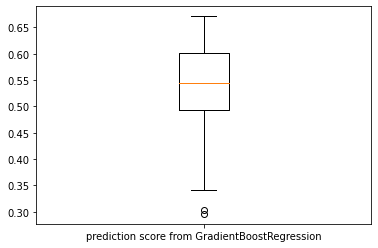

The mean is 0.540163463403074 and the standard deviation is 0.07775095217963553.


In [ ]:
fig = plt.figure()  
ax = plt.subplot()  
ax.boxplot(score)
ax.set_xticklabels(['prediction score from GradientBoostRegression'])
plt.show()
print("The mean is {} and the standard deviation is {}.".format(np.mean(score), np.sqrt(np.var(score))))

### XGBoost Regressor

[08:58:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

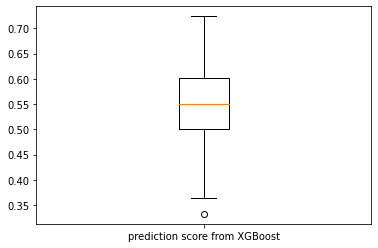

The mean is 0.5475158323872082 and the standard deviation is 0.07956639495692577.


In [ ]:
score = [0 for i in range(100)]
for i in range(100):
    order = np.arange(movies_num)
    np.random.shuffle(order)
    x_train = x.values[order][:3000]
    x_test = x.values[order][3000:]
    y_train = y.values[order][:3000]
    y_test = y.values[order][3000:]
    model_xgb = XGBRegressor()
    model_xgb.fit(x_train, y_train)
    score[i] = model_xgb.score(x_test, y_test)

fig = plt.figure()  
ax = plt.subplot()  
ax.boxplot(score)
ax.set_xticklabels(['prediction score from XGBoost'])
plt.show()
print("The mean is {} and the standard deviation is {}.".format(np.mean(score), np.sqrt(np.var(score))))

Now we include all the variables and see whether there are any improvements.

## 3 - 2. Selecting All feautures

### Gradient Boosting Regression

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_final.csv')
genres = preprocess("genres")
df = updatefile(genres, 'genres', df)
production_companies = preprocess("production_companies")
df = updatefile(production_companies, 'production_companies', df)
df['release_date'] =pd.to_datetime(df['release_date'], format = "%Y-%m-%d")
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_day'] = df['release_date'].dt.day
df.drop(columns=['release_date'], inplace = True)
keywords = preprocess("keywords")
df = updatefile(keywords, 'keywords', df)
cast = preprocess("cast")
df = updatefile(cast, 'cast', df)
crew = preprocess('crew')
df = updatefile(crew, 'crew', df)
df.columns = df.columns.str.replace(' ', '_')
for i in range(len(df)):
    if df['budget'][i] == 0:
        df['budget'][i] = df['revenue'][i]/3

# columns before constraint: 19
# columns after constraint: 19
# columns before constraint: 3736
# columns after constraint: 300
# columns before constraint: 8828
# columns after constraint: 1130
# columns before constraint: 46307
# columns after constraint: 2283
# columns before constraint: 45396
# columns after constraint: 3833


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
score = [0 for i in range(100)]
for i in range(100):
    order = np.arange(movies_num)
    np.random.shuffle(order)
    x_train = x.values[order][:3000]
    x_test = x.values[order][3000:]
    y_train = y.values[order][:3000]
    y_test = y.values[order][3000:]
    model_gbr = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.05,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=250,
                                                 n_iter_no_change=None,
                                                 presort='deprecated',
                                                 random_state=None,
                                                 subsample=1.0, tol=0.0001,
                                                 validation_fraction=0.1,
                                                 verbose=0, warm_start=False)
    model_gbr.fit(x_train, y_train)
    score[i] = model_gbr.score(x_test, y_test)

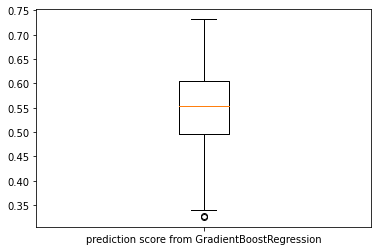

The mean is 0.5496611800421437 and the standard deviation is 0.07963745752633943.


In [ ]:
fig = plt.figure()  
ax = plt.subplot()  
ax.boxplot(score)
ax.set_xticklabels(['prediction score from GradientBoostRegression'])
plt.show()
print("The mean is {} and the standard deviation is {}.".format(np.mean(score), np.sqrt(np.var(score))))

### XGB Regressor

In [ ]:
xgb = XGBRegressor()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.05, 0.1, 0.2]
}
best_xgb = GridSearchCV(estimator= xgb, param_grid= parameters, cv=5)
best_xgb.fit(x_train, y_train)

[09:14:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:14:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:14:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:14:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:14:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:14:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:14:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:14:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [1, 3, 5, 7, 9],
                 

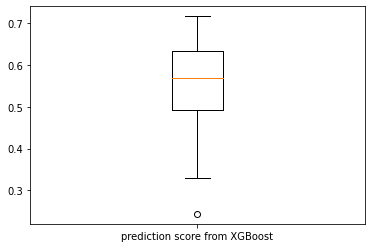

The mean is 0.5565000028748454 and the standard deviation is 0.09568126106978278.


In [ ]:
score = [0 for i in range(100)]
for i in range(100):
    order = np.arange(movies_num)
    np.random.shuffle(order)
    x_train = x.values[order][:3000]
    x_test = x.values[order][3000:]
    y_train = y.values[order][:3000]
    y_test = y.values[order][3000:]
    model_xgb = XGBRegressor(base_score= 0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=250, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=0)
    model_xgb.fit(x_train, y_train)
    score[i] = model_xgb.score(x_test, y_test)

fig = plt.figure()  
ax = plt.subplot()  
ax.boxplot(score)
ax.set_xticklabels(['prediction score from XGBoost'])
plt.show()
print("The mean is {} and the standard deviation is {}.".format(np.mean(score), np.sqrt(np.var(score))))

Another experiment will be fixing some of the revenues that seems suspicious.

In [ ]:
df.sort_values(by = 'revenue').head(35)

,revenue,budget,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science_Fiction,Thriller,War,Western,1492_Pictures,21_Laps_Entertainment,2929_Productions,3_Arts_Entertainment,40_Acres_&_A_Mule_Filmworks,A_Band_Apart,A24,Affirm_Films,Alcon_Entertainment,Alliance_Films,Alphaville_Films,Amblin_Entertainment,American_Zoetrope,Annapurna_Pictures,Anonymous_Content,Anton_Capital_Entertainment_(ACE),Apatow_Productions,Appian_Way,Artisan_Entertainment,...,Tribeca_Productions,Troublemaker_Studios,Twentieth_Century_Fox_Animation,Twentieth_Century_Fox_Film_Corporation,Twisted_Pictures,Téléfilm_Canada,UK_Film_Council,United_Artists,Universal_Pictures,Universal_Studios,Valhalla_Motion_Pictures,Vertigo_Entertainment,View_Askew_Productions,Village_Roadshow_Pictures,Virtual_Studios,WWE_Studios,Walden_Media,Walt_Disney,Walt_Disney_Animation_Studios,Walt_Disney_Feature_Animation,Walt_Disney_Pictures,Walt_Disney_Productions,Walt_Disney_Studios_Motion_Pictures,Warner_Bros.,Warner_Bros._Pictures,Warner_Independent_Pictures_(WIP),Weed_Road_Pictures,Westdeutscher_Rundfunk_(WDR),Wild_Bunch,WingNut_Films,Wintergreen_Productions,Wonderland_Sound_and_Vision,Working_Title_Films,Worldview_Entertainment,X-Filme_Creative_Pool,Yari_Film_Group,Zide-Perry_Productions,release_year,release_month,release_day
2731,5,7,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1992,5,1
3014,7,2000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1999,10,29
2753,7,7,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2009,8,9
2760,10,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1999,10,22
2462,11,11,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1978,4,26
2586,11,10,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013,8,30
1509,12,23000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2004,1,9
2148,12,16000000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2004,9,3
1721,13,25,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1999,12,25
1603,14,28,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2001,12,7


There seems to be some values like the ones in the index 3014, 1509 and such which have unacceptable values with respect to the budget. I assumed that they are wrongly inputed, maybe due to different unit problems. I will only fix the values that seems totally wrong and adjust their units as same as their budget values while keeping their original numbers. (i.e index 3014 : (7, 2000000) -> (7000000, 2000000))

In [ ]:
df['revenue'][3014] = 7000000
df['revenue'][1509] = 12000000
df['revenue'][2148] = 12000000
df['revenue'][2429] = 23000000
df['revenue'][1839] = 4600000

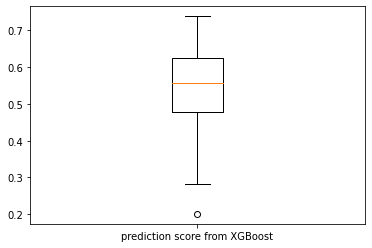

The mean is 0.5423006527021357 and the standard deviation is 0.10065342254641699.


In [ ]:
score = [0 for i in range(100)]
for i in range(100):
    order = np.arange(movies_num)
    np.random.shuffle(order)
    x_train = x.values[order][:3000]
    x_test = x.values[order][3000:]
    y_train = y.values[order][:3000]
    y_test = y.values[order][3000:]
    model_xgb = XGBRegressor(base_score= 0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=250, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=0)
    model_xgb.fit(x_train, y_train)
    score[i] = model_xgb.score(x_test, y_test)

fig = plt.figure()  
ax = plt.subplot()  
ax.boxplot(score)
ax.set_xticklabels(['prediction score from XGBoost'])
plt.show()
print("The mean is {} and the standard deviation is {}.".format(np.mean(score), np.sqrt(np.var(score))))

Maybe not a good idea...

## 3-3. Standarization
My final experiment will be standarizing the budget values using standard scalar function which centralizes the values of the mean to zero and the standard deviation to one. Especially in regression analysis, standarization is important when datas that are compared have different units. 

In [5]:
df = pd.read_csv('/content/drive/MyDrive/data_final.csv')
genres = preprocess("genres")
df = updatefile(genres, 'genres', df)
production_companies = preprocess("production_companies")
df = updatefile(production_companies, 'production_companies', df)
df['release_date'] =pd.to_datetime(df['release_date'], format = "%Y-%m-%d")
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_day'] = df['release_date'].dt.day
df.drop(columns=['release_date'], inplace = True)
keywords = preprocess("keywords")
df = updatefile(keywords, 'keywords', df)
cast = preprocess("cast")
df = updatefile(cast, 'cast', df)
crew = preprocess('crew')
df = updatefile(crew, 'crew', df)
df.columns = df.columns.str.replace(' ', '_')
for i in range(len(df)):
    if df['budget'][i] == 0:
        df['budget'][i] = df['revenue'][i]/3
x = df.drop(columns = 'revenue')
y = np.log(df['revenue']+1.0)
scaler = StandardScaler()
# df['budget'] = scaler.fit_transform(df['budget'].values.reshape(-1,1)) 

# columns before constraint: 19
# columns after constraint: 19
# columns before constraint: 3736
# columns after constraint: 300
# columns before constraint: 8828
# columns after constraint: 1130
# columns before constraint: 46307
# columns after constraint: 2283
# columns before constraint: 45396
# columns after constraint: 3833


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


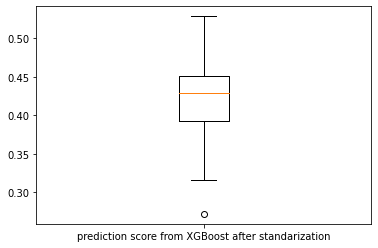

The mean is 0.4238910306789295 and the standard deviation is 0.04382008503468487.


In [ ]:
movies_num = np.shape(x)[0]
score = [0 for i in range(100)]
for i in range(100):
    order = np.arange(movies_num)
    np.random.shuffle(order)
    x_train = x.values[order][:3000]
    x_test = x.values[order][3000:]
    y_train = y.values[order][:3000]
    y_test = y.values[order][3000:]
    model_xgb = XGBRegressor(base_score= 0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=250, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=0)
    model_xgb.fit(x_train, y_train)
    score[i] = model_xgb.score(x_test, y_test)

fig = plt.figure()  
ax = plt.subplot()  
ax.boxplot(score)
ax.set_xticklabels(['prediction score from XGBoost after standarization'])
plt.show()
print("The mean is {} and the standard deviation is {}.".format(np.mean(score), np.sqrt(np.var(score))))

## 4. Result Table and Conclusion

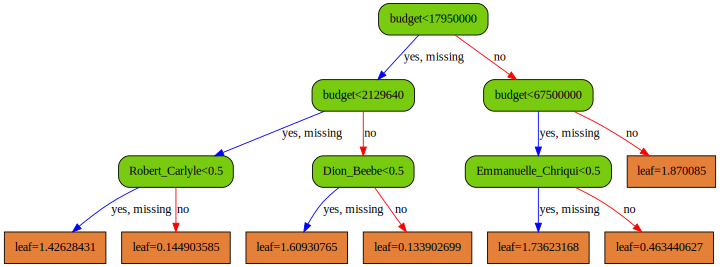

In [37]:
model_xgb = xgb.XGBRegressor(base_score= 0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=6,
                                    min_child_weight=1, missing=None,
                                    n_estimators=1, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=0)
model_xgb.fit(x_train, y_train)
node_params = {'shape': 'box', 'style': 'filled, rounded','fillcolor': '#78cbe'}
leaf_params = {'shape': 'box', 'style': 'filled', 'fillcolor': '#e48038'}
feature_names = list()
for i in range(len(x.columns)):
  feature_names.append(x.columns.values[i])
model_xgb.get_booster().feature_names = feature_names
xgb.to_graphviz(model_xgb.get_booster(), num_trees =0, size = "10,10", 
                condition_node_params = node_params,
               leaf_node_params = leaf_params)


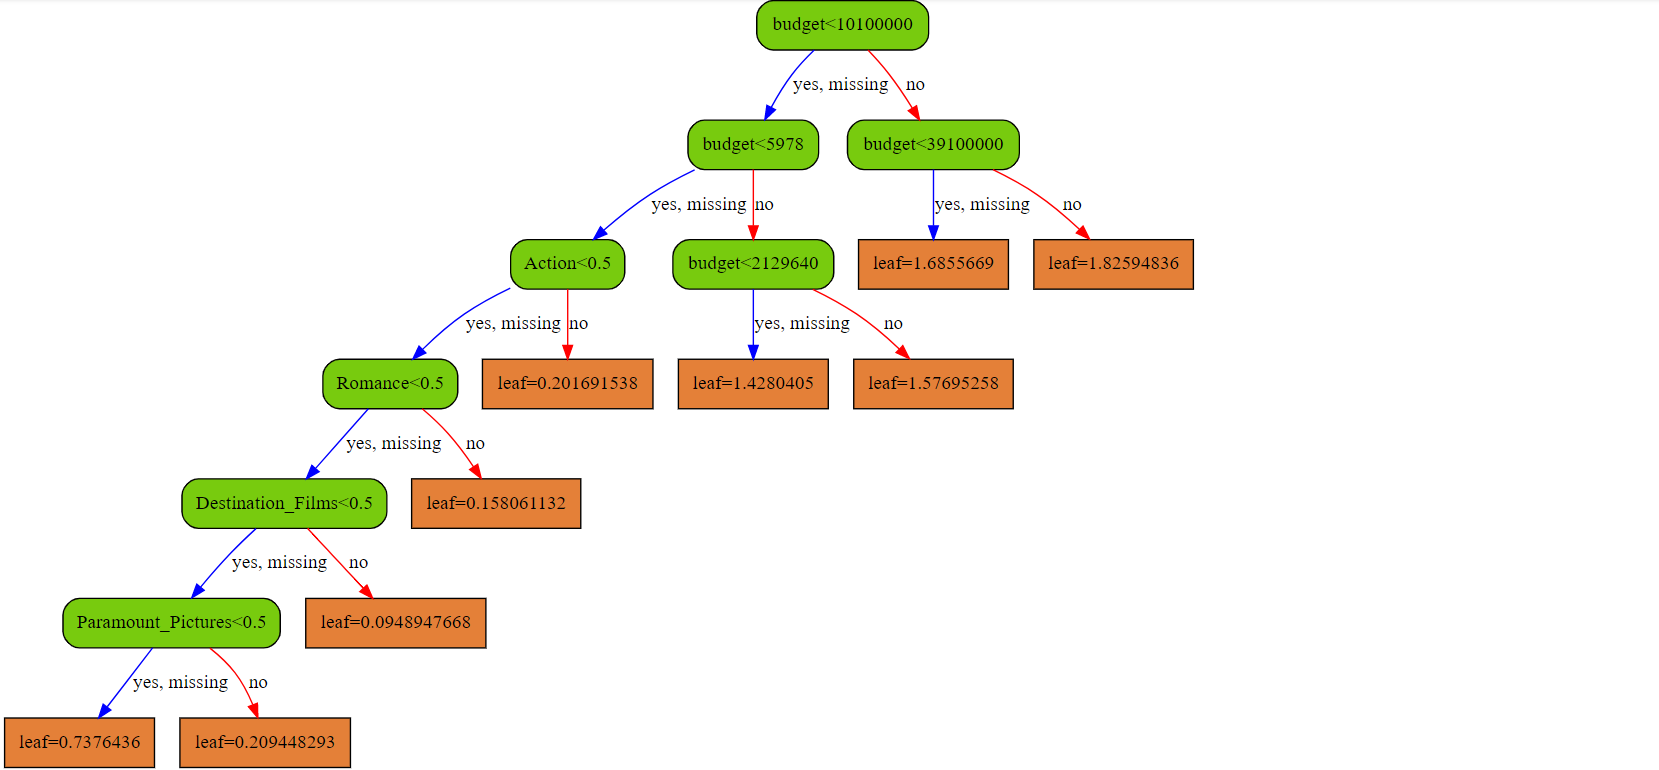

This is the architecture of the decision tree for the XGB regression model that I implemented. Note that for the visualization, I have increased the max_depth to 6 and made the number of estimators(i.e number of trees) to 1. For the actual models, the max_depth was set to 3 and the number of estimators were 250. When moving the .ipynb file to jupyter, the output image kept on failing to upload, therefore I had to just screenshot the image and paste it here.

### Feature Importance

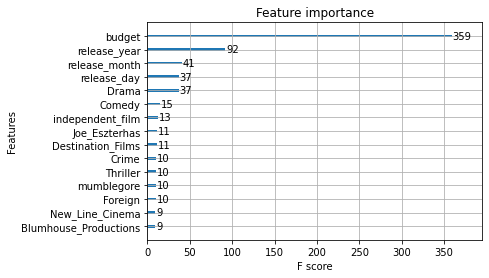

In [22]:
feature_names = list()
for i in range(len(x.columns)):
  feature_names.append(x.columns.values[i])
model_xgb.get_booster().feature_names = feature_names
plot_importance(model_xgb, max_num_features=15)

### Budget & log_Revenue plot

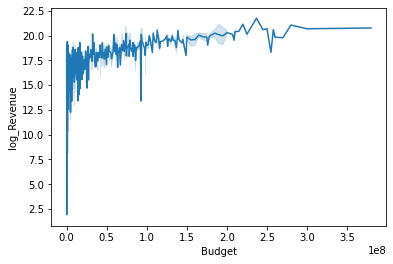

In [61]:
budget_revenue = pd.DataFrame({"Budget": x['budget'],"log_Revenue": y})
sns.lineplot(x = "Budget", y = "log_Revenue", data=budget_revenue)

### release_year & log_Revenue scatter plot

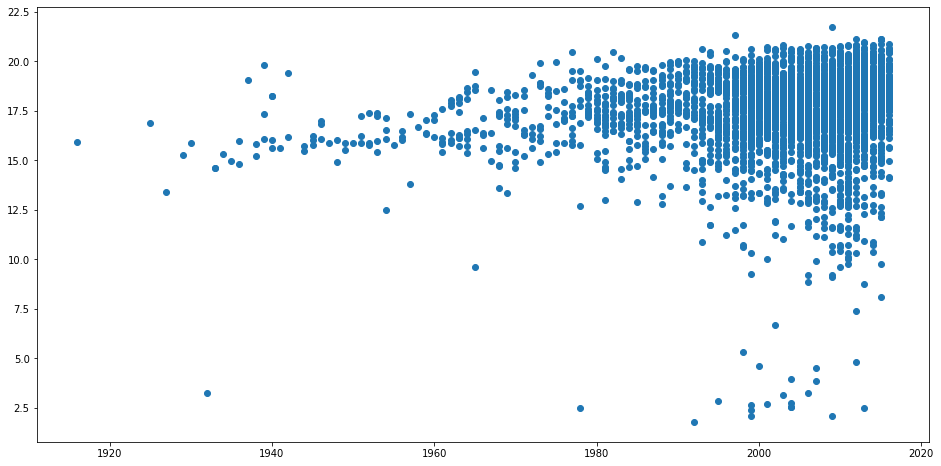

In [66]:
plt.figure(figsize=(16,8))
plt.scatter(x['release_year'], y)

### release_day & log_Revenue catplot

Text(0.5, 1.0, 'log_Revenue per release month')

<Figure size 1152x576 with 0 Axes>

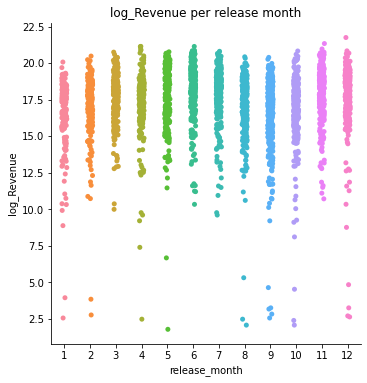

In [71]:
plt.figure(figsize=(16,8))
month_revenue = pd.DataFrame({"release_month": x['release_month'],"log_Revenue": y})
sns.catplot(x='release_month', y='log_Revenue', data=month_revenue)
plt.title('log_Revenue per release month')


In [ ]:
1 [0.003439, 0.778571]
2 [0.003079, 0.699524]
3 [0.003602, 0.695714]
4 [0.003987, 0.7800]
5 [0.003353, 0.755238]
6 [0.003198, 0.803810]
7 [0.002839, 0.738095]

(0.0, 1.0, 0.0, 1.0)

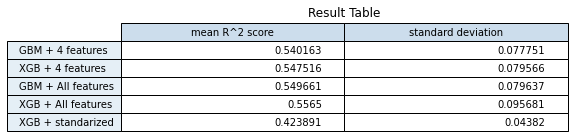

In [ ]:
result = np.array([0.540163,0.077751,0.547516,0.079566,0.549661,0.079637,
                   0.556500,0.095681,0.423891,0.043820])
result = pd.DataFrame(result.reshape(5,2))
result.columns= ['mean R^2 score', 'standard deviation']
result.index = ['GBM + 4 features', 'XGB + 4 features', 'GBM + All features', 
                'XGB + All features', 'XGB + standarized']

fig = plt.figure(figsize = (8,2))
ax = plt.subplot()  
table = ax.table(cellText = result.values,
         rowLabels = result.index,
         rowColours = plt.cm.BuPu(np.full(len(result.index),0.1)),
         colLabels = result.columns, 
        colColours = plt.cm.BuPu(np.full(len(result.columns),0.2)),
        loc = 'center')
ax.set_title("Result Table")
table.scale(1,1.5)
ax.axis("off")

### Final Remark 

The highest R^2 score that I got for my experiments in this project was 0.5565 using XGBoost model with all of the features included. I have performed exploratory data analysis after extracting the feature importance because some of the features were self- intuitive and for the others, since after the multi label encoding step, the data became a bit messy. This was the very first time for me to actually do a machine learning project and it was very exciting and helpful to my understanding of the models. Also, I was able to experience  processing the data rightly for use and perform experimenting with those data. I believe my project could be further improved if I get more knowledge of how to optimize feature engineering. 

Reference : <br>
https://www.kdnuggets.com/2018/08/unveiling-mathematics-behind-xgboost.html
https://xgboost.readthedocs.io/en/latest/
https://www.frontiersin.org/articles/10.3389/fgene.2019.00459/full <br>
https://medium.com/analytics-vidhya/predicting-house-prices-using-classical-machine-learning-and-deep-learning-techniques-ad4e55945e2d <br>
https://www.overleaf.com/learn/latex/tables